# Comparing ODE methods with adaptive time stepping

In [181]:
import numpy as np
import matplotlib.pylab as plt

# Morris-Lecar Biological Neuron Model: 

$ \frac{dv}{dt} = - 0.11\Big[1 + \tanh\Big(\frac{v + 1}{15}\Big) \Big] (v-100) - 0.4w(v+70) - 0.1(v+50) + J(t) $
 
$ \frac{dw}{dt} = 0.03\cosh\Big(\frac{v}{60}\Big) \Big[1 + \tanh \Big(\frac{v}{30}) - 2w \Big] $

With initial conditions:
$v(0) = -20$, $w(0) = 0$ and $J(t) = 6$. 

In [182]:
# The Morris Lecar DE function
def morris_lecar(t, z):
    global f_evals
    f_evals += 1

    dvdt = -.11*(1+np.tanh((z[0]+1)/15))*(z[0]-100) - 0.4*z[1]*(z[0]+70) - .1*(z[0] + 50) + 6
    dwdt = .01 * np.cosh(z[0]/60)*(1+np.tanh(z[0]/30)-2*z[1])

    return np.array([dvdt,dwdt]), f_evals

The Morris-Lecar DE will be the function utilized to compare ODE23 mothodologies within this experiment. 

In [183]:
# Creation of the Original ODE23 method uzilized
def ode23(de_fcn, tspan, y0, tol, h0, maxh):

    t_history = [tspan[0]]
    y_history = [y0]
    a_history = [1]
    f_evals = 0
    h_history = [h0]

    h = h0
    t = tspan[0]
    y = np.array(y0)
    alpha = 1

    
    # Loop until you reach the end time
    while t<=tspan[1]:
        # Midpoint
        k0, f_evals = de_fcn(t, y)
        k1, f_evals = de_fcn(t + 0.5*h, y + 0.5*h*k0)
        y_m = y + h*k1

        # Runge-Kutta 
        k2, f_evals = de_fcn(t + .75*h, y + 0.75*h*k1)
        y_rk3 = y + h*(2*k0/9 + k1/3 + 4*k2/9)

        # Error and gamma factor
        e = np.linalg.norm(y_m - y_rk3)
        gamma = (tol/e)**(1/3)

        if e <= tol:
            # Saving the step
            y_history.append(y_rk3.tolist())
            t_history.append(t)

            y = y_rk3
            t = t + h

            # Creating of the next optimal h
            alpha = 1.05 * alpha
            h_opt = h * gamma * alpha
            h = min(h_opt, maxh)

            # Appending Step Variables
            a_history.append(alpha)
            h_history.append(h_opt)

        # When the Tolerence is not met:
        else:
            alpha = .7 * alpha
            h_opt = h * gamma * alpha
            h = min(h_opt, maxh)

            # Appending Step Variables
            a_history.append(alpha)
            h_history.append(h_opt)

    return np.array(y_history), np.array(t_history), f_evals, a_history, h_history

In [184]:
# Evaluating the function
f_evals = 0
base_results = ode23(morris_lecar, [0,400], [-20, 0], tol=0.1, h0=1., maxh=6)

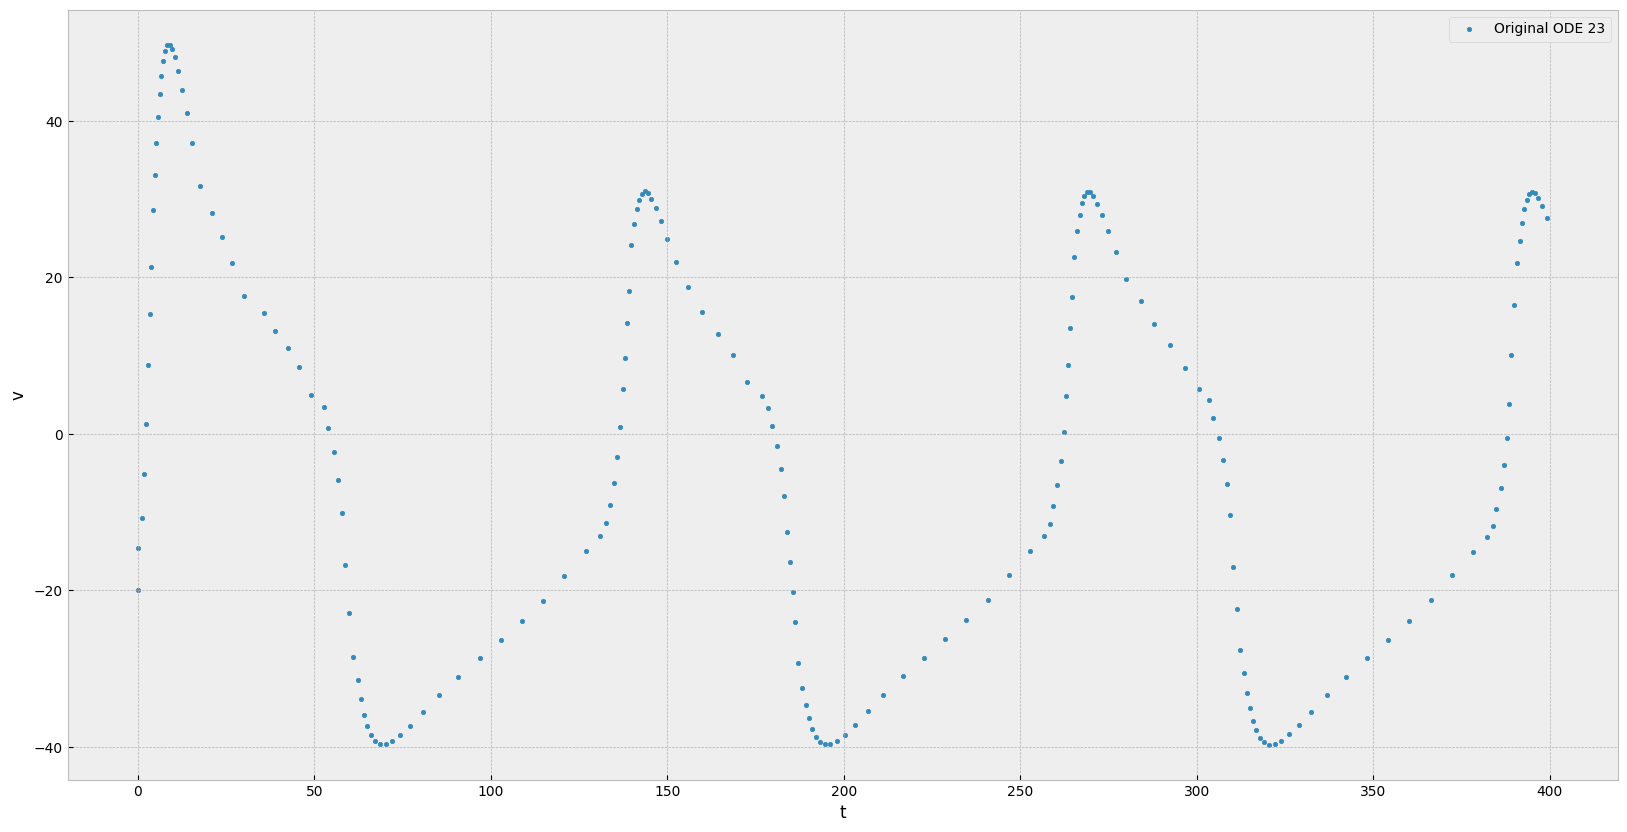

In [185]:
# Plotting the solution
plt.style.use('bmh')

fig, ax = plt.subplots(figsize=(20,10))
ode23 = ax.scatter(base_results[1], base_results[0][:,0], s=10)
ax.set_xlabel("t")
ax.set_ylabel("v")
ax.legend([ode23], ['Original ODE 23'])

plt.show()

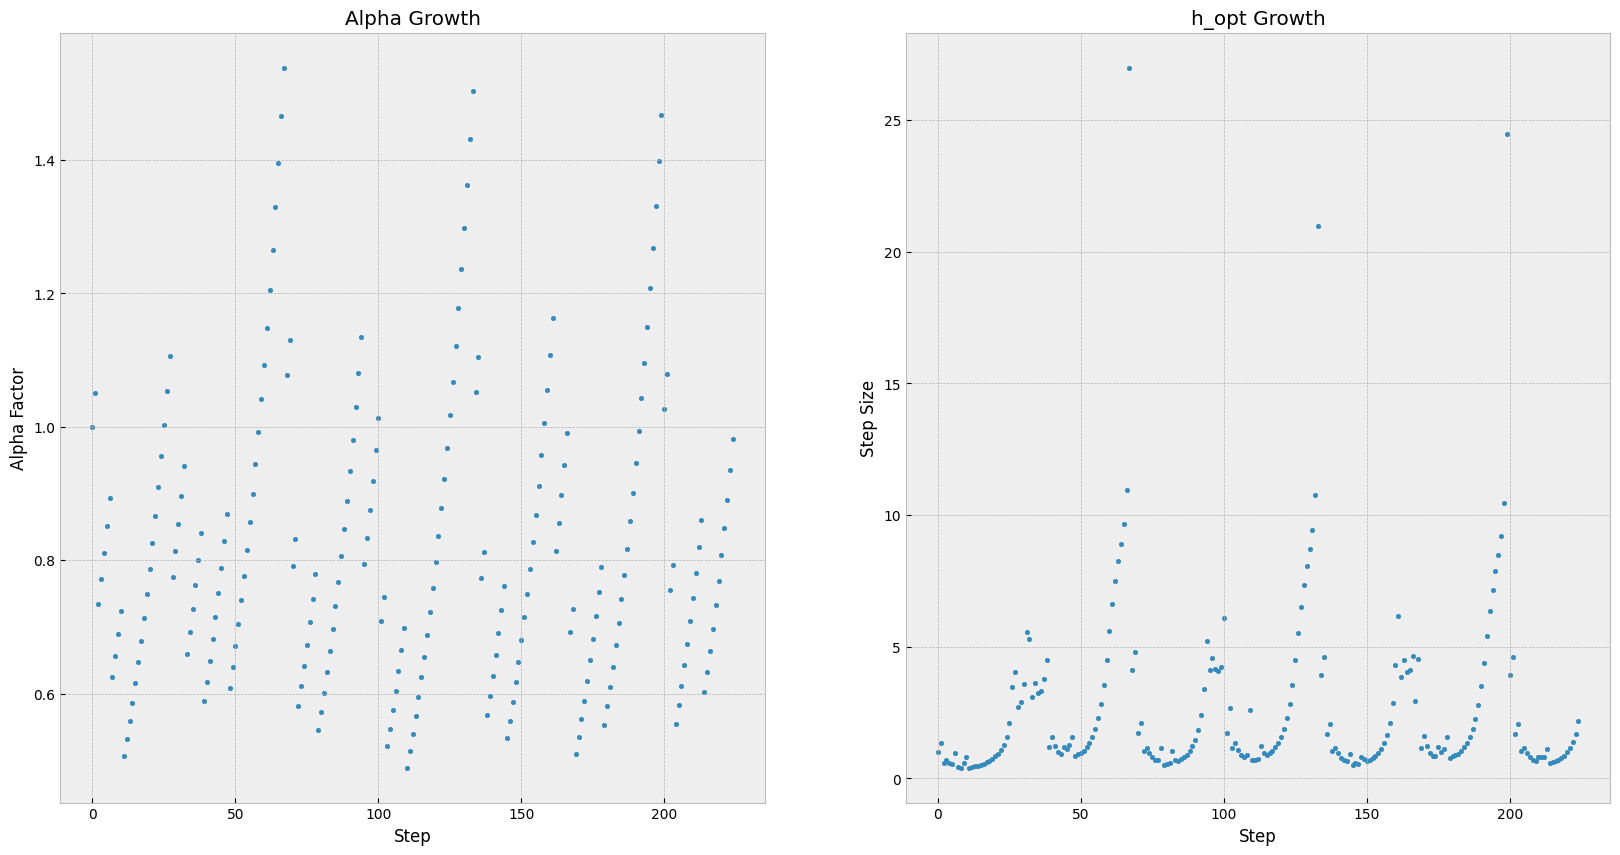

In [186]:
# Plotting the Alpha growth and h optimal growth
plt.style.use('bmh')
fig, ax = plt.subplots(1,2, figsize=(20,10))
ax[0].scatter(np.arange(0,len(base_results[3]),1), base_results[3], s=10)
ax[0].set_title('Alpha Growth')
ax[0].set_xlabel("Step")
ax[0].set_ylabel("Alpha Factor")

ax[1].scatter(np.arange(0,len(base_results[4]),1), base_results[4], s=10)
ax[1].set_title('h_opt Growth')
ax[1].set_xlabel("Step")
ax[1].set_ylabel("Step Size")

plt.show()

This confirms the idea that alpha, and subsequetly h_opt, grows largely in the background when it surpasses the h_max theshold. This leads to the idea that when a step size fails, the h_optimal may not decrease fast enough to reajust.

In [187]:
# Redefining the ODE function
def ode23(de_fcn, tspan, y0, tol, h0, maxh):

    t_history = [tspan[0]]
    y_history = [y0]
    a_history = [1]
    f_evals = 0
    h_history = [h0]

    h = h0
    t = tspan[0]
    y = np.array(y0)
    alpha = 1

    
    # Looping until we reach tspan
    while t<=tspan[1]:
        # Midpoint
        k0, f_evals = de_fcn(t, y)
        k1, f_evals = de_fcn(t + 0.5*h, y + 0.5*h*k0)
        y_m = y + h*k1

        # Runge-Kutta 
        k2, f_evals = de_fcn(t + .75*h, y + 0.75*h*k1)
        y_rk3 = y + h*(2*k0/9 + k1/3 + 4*k2/9)

        # Error and gamma factor
        e = np.linalg.norm(y_m - y_rk3)
        gamma = (tol/e)**(1/3)

        if e <= tol:
            # Saving the step
            y_history.append(y_rk3.tolist())
            t_history.append(t)

            y = y_rk3
            t = t + h
            h_opt = h * gamma * alpha

            # Creating of the next optimal h
            if h_opt == min(h_opt, maxh):
                alpha = 1.05 * alpha
                h_opt = h * gamma * alpha
                h = h_opt
            else: 
                h = maxh

            # Appending Step Variables
            a_history.append(alpha)
            h_history.append(h_opt)

        # When the Tolerence is not met:
        else:
            alpha = .70 * alpha
            h_opt = h * gamma * alpha
            h = min(h_opt, maxh)

            # Appending Step Variables
            a_history.append(alpha)
            h_history.append(h_opt)
    
    return np.array(y_history), np.array(t_history), f_evals, a_history, h_history

In [188]:
# Evaluating the function
f_evals = 0
updated_results = ode23(morris_lecar, [0,400], [-20, 0], tol=0.1, h0=1., maxh=6)

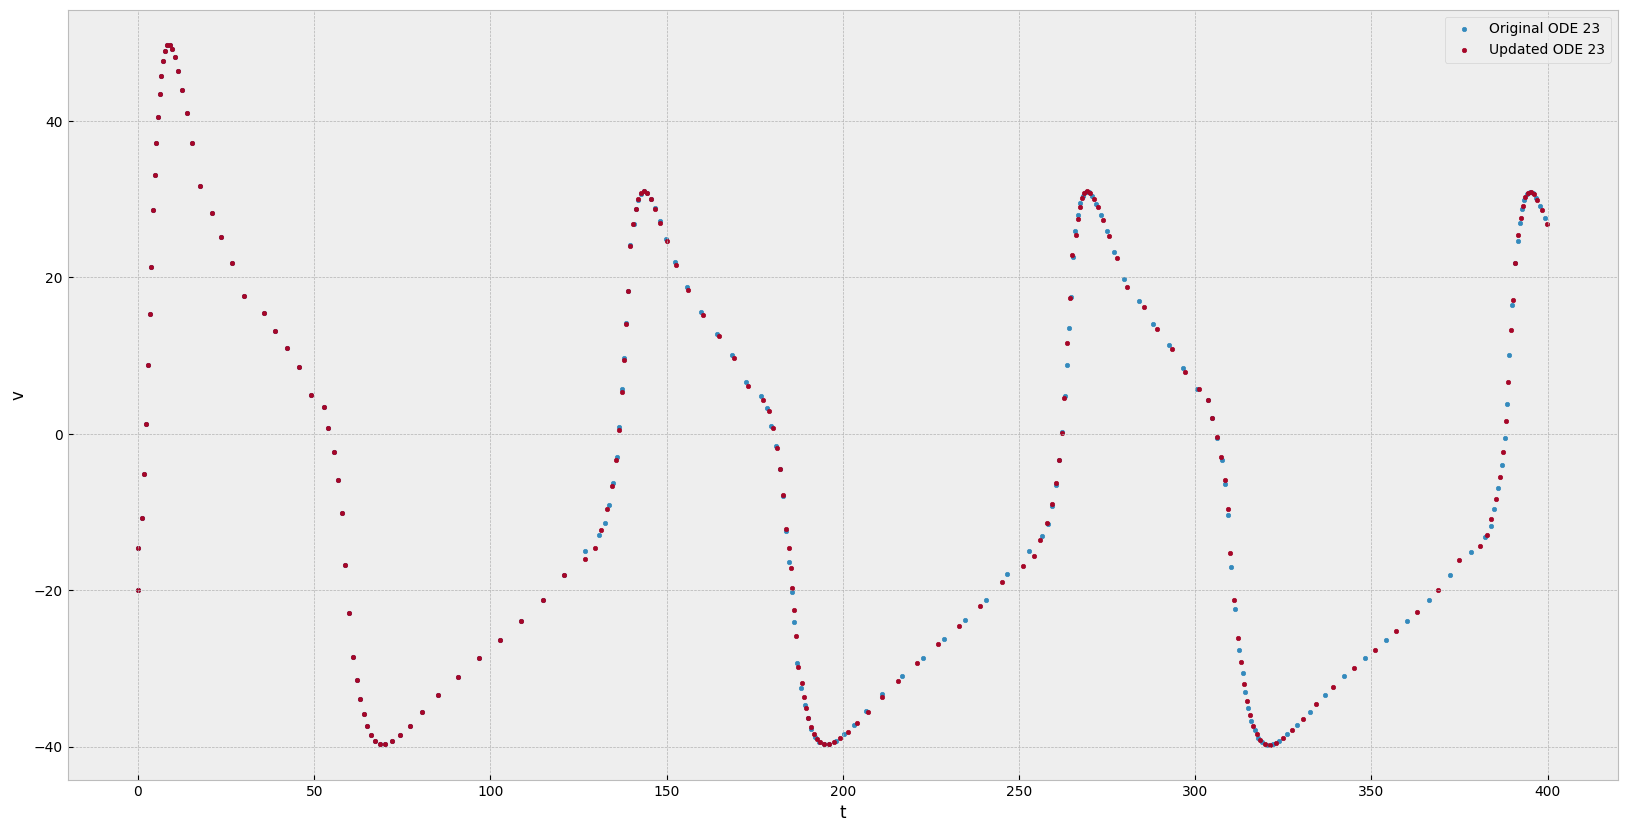

In [189]:
# Plotting the solution
plt.style.use('bmh')

fig, ax = plt.subplots(figsize=(20,10))
ode23 = ax.scatter(base_results[1], base_results[0][:,0], s=10)
ode23_u = ax.scatter(updated_results[1], updated_results[0][:,0], s=10)
ax.set_xlabel("t")
ax.set_ylabel("v")
ax.legend([ode23, ode23_u], ['Original ODE 23', 'Updated ODE 23'])

plt.show()

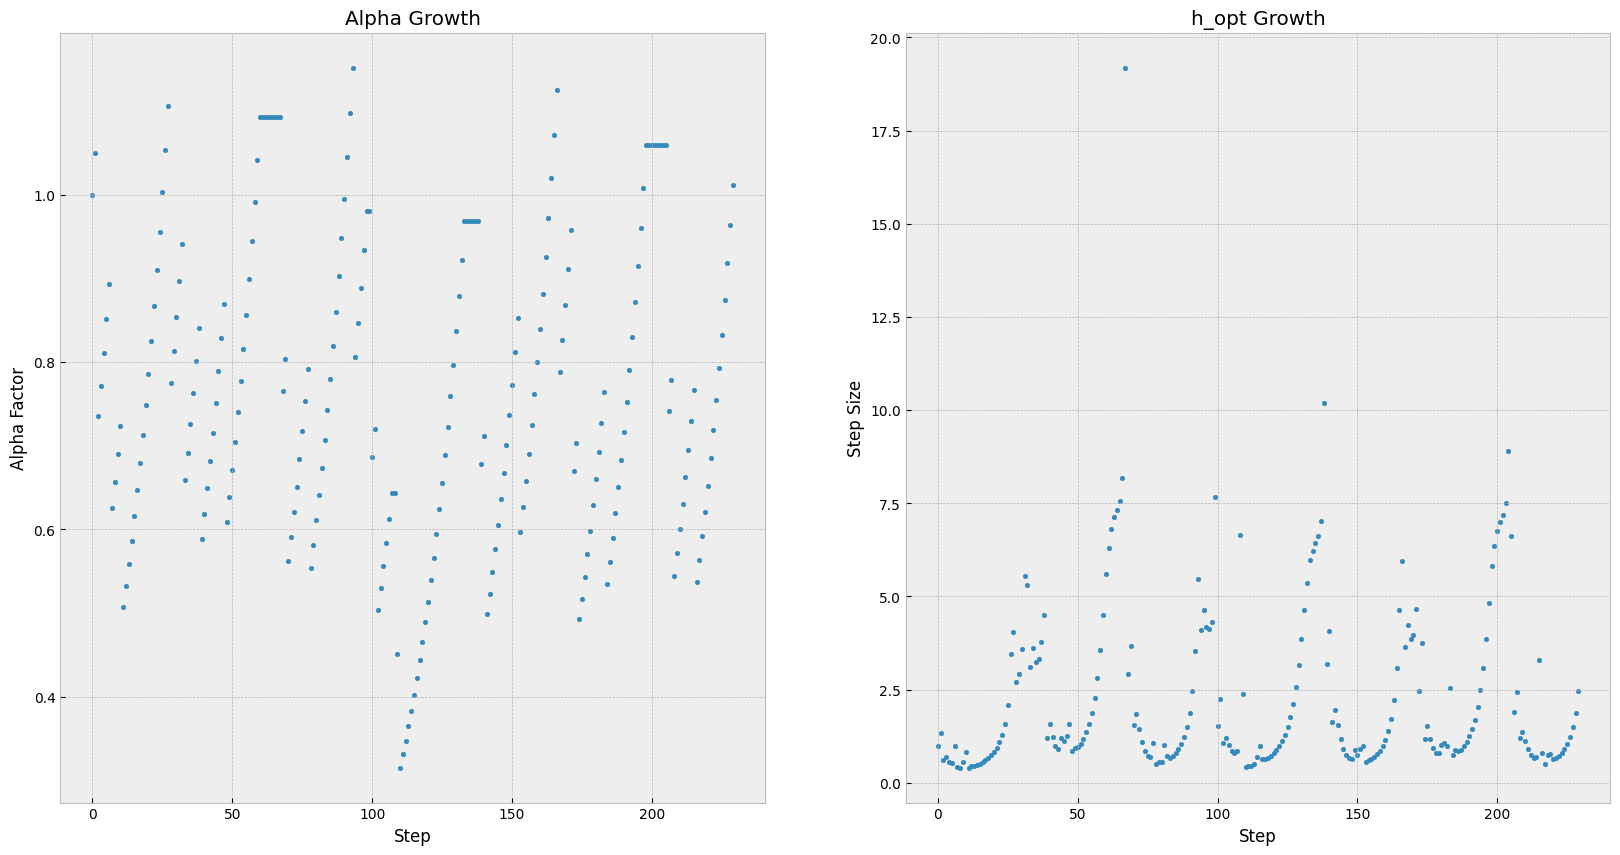

In [190]:
plt.style.use('bmh')

fig, ax = plt.subplots(1,2, figsize=(20,10))
ax[0].scatter(np.arange(0,len(updated_results[3]),1), updated_results[3], s=10)
ax[0].set_title('Alpha Growth')
ax[0].set_xlabel("Step")
ax[0].set_ylabel("Alpha Factor")

ax[1].scatter(np.arange(0,len(updated_results[4]),1), updated_results[4], s=10)
ax[1].set_title('h_opt Growth')
ax[1].set_xlabel("Step")
ax[1].set_ylabel("Step Size")

plt.show()

In [191]:
print("Updated ODE method's steps:", len(updated_results[1]))
print("Previous ODE metho's steps:", len(base_results[1]))

Updated ODE method's steps: 205
Previous ODE metho's steps: 198


This seems to indicate that there may be some optimization methods to be implemented to configuration the growth and contracting factors. Let us now set $\theta$ as the growth factor, and $\phi$ as the contraction factor. Given that alpha is no longer updated when the max_h step is utilized suggests that the contraction $\phi$ could be reduced (approach 1). Let us then explore this idea with the implementation of a theta paramater, where $\theta$ = theta +1, $\phi$ = 1 - theta

In [192]:
# Redefining the ODE23 function with added theta paramater
def ode23(de_fcn, tspan, y0, tol, h0, maxh, theta):

    # Initializing history lists
    t_history = [tspan[0]]
    y_history = [y0]
    a_history = [1]
    h_history = [h0]
    e_history = []

    # Initializing Variables
    f_evals = 0
    Theta = 1 + theta
    Phi = 1 - theta
    h = h0
    t = tspan[0]
    y = np.array(y0)
    alpha = 1
    
    # Looping until we reach tspan
    while t<=tspan[1]:

        # Midpoint Method
        k0, f_evals = de_fcn(t, y)
        k1, f_evals = de_fcn(t + 0.5*h, y + 0.5*h*k0)
        y_m = y + h*k1

        # Runge-Kutta Method
        k2, f_evals = de_fcn(t + .75*h, y + 0.75*h*k1)
        y_rk3 = y + h*(2*k0/9 + k1/3 + 4*k2/9)

        # Error and Gamma factors
        e = np.linalg.norm(y_m - y_rk3)
        gamma = (tol/e)**(1/3)

        e_history.append(e)


        # Step Size Error Analysis
        if e <= tol:
            # Tolerence is met: Acceptible Step Size -> Saving the step values
            y_history.append(y_rk3.tolist())
            t_history.append(t)

            y = y_rk3
            t = t + h
            h_opt = h * gamma * alpha

            # Identification of the next optimal h: this prevents alpha from growing in the instance that h_opt > maxh 
            if h_opt == min(h_opt, maxh):
                alpha = Theta * alpha
                h_opt = h * gamma * alpha
                h = h_opt

            else: 
                h = maxh

            # Appending history variables
            h_history.append(h_opt)
            a_history.append(alpha)

        # Tolerence has not been met: Unacceptiable Step Size -> reattempting step size with alpha contraction
        else:
            alpha = Phi * alpha
            h_opt = h * gamma * alpha
            h = min(h_opt, maxh)

            # Appending Step Variables
            a_history.append(alpha)
            h_history.append(h_opt)
    
    return np.array(y_history), np.array(t_history), f_evals, a_history, h_history, e_history

Now let us locate the Optimal Theta value iterating through a list from 0.1 to .2 (inclusively)

In [193]:
theta = np.arange(0.01, .21, 0.01)
residuals = []
Theta_eval = []

for i in range(len(theta)):
    ode23_results = ode23(morris_lecar, [0,400], [-20, 0], tol=0.1, h0=1., maxh=6, theta=theta[i])
    norm = np.linalg.norm(ode23_results[5])
    residuals.append(norm)

Dic = {residuals[i]: theta[i] for i in range(len(theta))}
print("Optimal Theta:", Dic[min(residuals)])

Optimal Theta: 0.15


Therefore, we conclude that the Optimal Theta varaible is of .15. Therefore: $\theta = 1.15, \ \phi = .85$

In [194]:
# Finalized ODE23 function
def ode23(de_fcn, tspan, y0, tol, h0, maxh, theta):

    '''ODE 23 is an Numerical ODE method of Order two and three with adaptive step size.
    This Second Order method is implemented in terms of the Trapezoid Method while that of 
    of the Third Order is of the Runge-Kutta method. 
    
    This final model incorporates the 
    optimal step sizing procedure based on the Morris-Lecar Biological Neuron Model. 

    This function evaluates the Differential Equation (de_fcn), given a time span (tspan), 
    initial value condition (y0), error tolerence (tol), intial step size (h0) and maximum step 
    size maxh.

    The Theta Variable has been identified as being the optimal growth and contraction value of
    the optimal step size. In prior implementations, this value is of .15. Theta = 1 + .15. Phi = 1 - .15. 
    '''

    # Initializing history lists
    t_history = [tspan[0]]
    y_history = [y0]
    a_history = [1]
    h_history = [h0]
    e_history = []

    # Initializing Variables
    f_evals = 0
    h = h0
    t = tspan[0]
    y = np.array(y0)
    alpha = 1
    
    # Looping until we reach tspan
    while t<=tspan[1]:

        # Midpoint Method
        k0, f_evals = de_fcn(t, y)
        k1, f_evals = de_fcn(t + 0.5*h, y + 0.5*h*k0)
        y_m = y + h*k1

        # Runge-Kutta Method
        k2, f_evals = de_fcn(t + .75*h, y + 0.75*h*k1)
        y_rk3 = y + h*(2*k0/9 + k1/3 + 4*k2/9)

        # Error and Gamma factors
        e = np.linalg.norm(y_m - y_rk3)
        gamma = (tol/e)**(1/3)

        e_history.append(e)


        # Step Size Error Analysis
        if e <= tol:
            # Tolerence is met: Acceptible Step Size -> Saving the step values
            y_history.append(y_rk3.tolist())
            t_history.append(t)

            y = y_rk3
            t = t + h
            h_opt = h * gamma * alpha

            # Identification of the next optimal h: this prevents alpha from growing in the instance that h_opt > maxh 
            if h_opt == min(h_opt, maxh):
                alpha = 1.15 * alpha
                h_opt = h * gamma * alpha
                h = h_opt

            else: 
                h = maxh

            # Appending history variables
            h_history.append(h_opt)
            a_history.append(alpha)

        # Tolerence has not been met: Unacceptiable Step Size -> reattempting step size with alpha contraction
        else:
            alpha = .85 * alpha
            h_opt = h * gamma * alpha
            h = min(h_opt, maxh)

            # Appending Step Variables
            a_history.append(alpha)
            h_history.append(h_opt)
    
    return np.array(y_history), np.array(t_history), f_evals, a_history, h_history, e_history

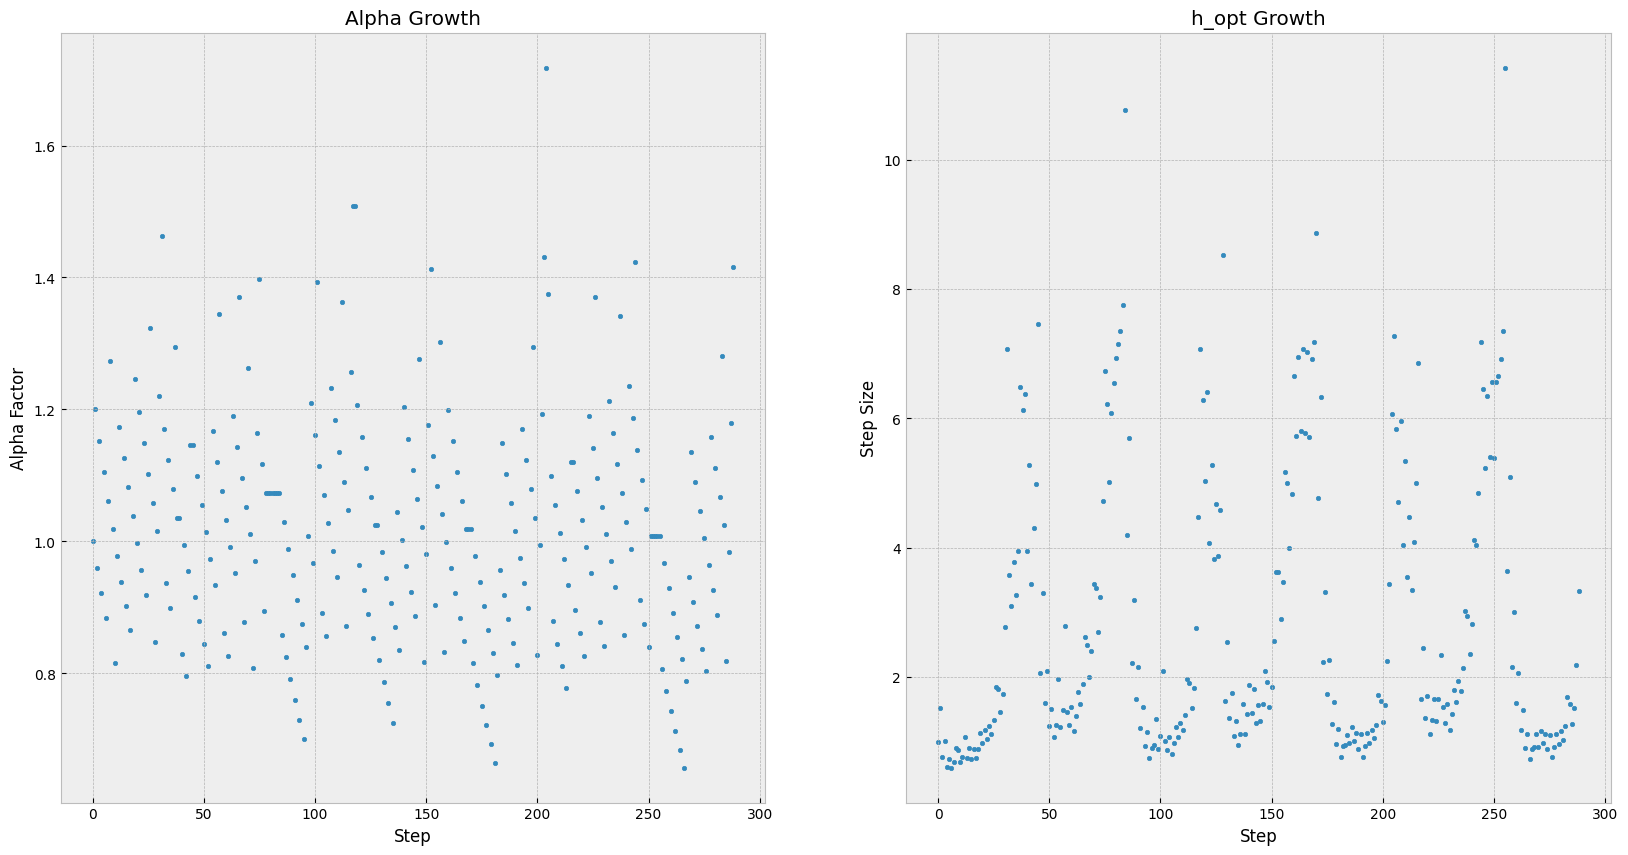

In [195]:
plt.style.use('bmh')

fig, ax = plt.subplots(1,2, figsize=(20,10))
ax[0].scatter(np.arange(0,len(ode23_results[3]),1), ode23_results[3], s=10)
ax[0].set_title('Alpha Growth')
ax[0].set_xlabel("Step")
ax[0].set_ylabel("Alpha Factor")

ax[1].scatter(np.arange(0,len(ode23_results[4]),1), ode23_results[4], s=10)
ax[1].set_title('h_opt Growth')
ax[1].set_xlabel("Step")
ax[1].set_ylabel("Step Size")

plt.show()

In [196]:
print("Updated ODE method steps:", len(ode23_results[1]))
print("Original ODE method steps:", len(base_results[1]))

Updated ODE method steps: 168
Original ODE method steps: 198


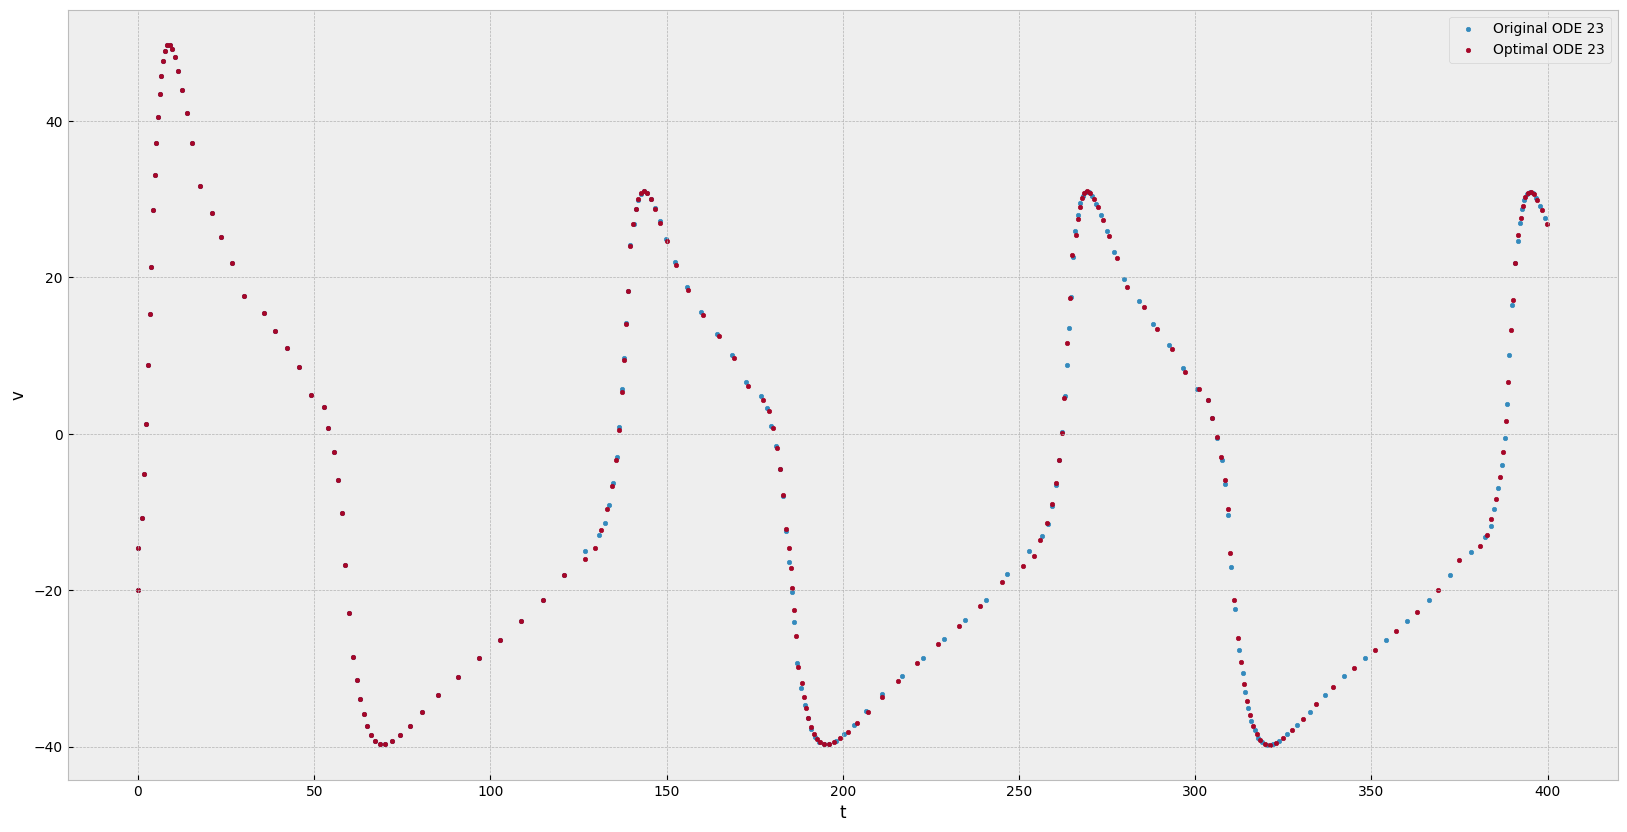

In [197]:
# Plotting the solution
plt.style.use('bmh')

fig, ax = plt.subplots(figsize=(20,10))
ode23 = ax.scatter(base_results[1], base_results[0][:,0], s=10)
ode23_u = ax.scatter(updated_results[1], updated_results[0][:,0], s=10)
ax.set_xlabel("t")
ax.set_ylabel("v")
ax.legend([ode23, ode23_u], ['Original ODE 23', 'Optimal ODE 23'])

plt.show()